# Nearest neighbor for image classification

In this notebook we will go through the idea behind the Nearest neighbor classifier, its shortcomings, its application to the MNIST dataset, and look at ways to improve the classifier to get better results

The problem that we will be solving today is that, given an image of a hand written digit, we need to output the correct digit that is represented within the image

## The MNIST dataset

The MNIST dataset of handwritten digits have the following data:
 - Training set of 60,000 images and their labels 
     -  We will use the training set to train a classifier (a function that takes an input an image and outputs what the correct digit is)
 
 
 - Test set of 10,000 images and their labels
     - We will use the test set to evaluate how good our classifier is

### Nearest Neighbor classification

We have a training set of 60,000 images, in order to classify a new image x, we simply look through this training set and find the image that is the closest to x, the nearest neighbor of x, and then we output the label of the nearest neighbor.

#### How to measure the measure distance between images?

In order to implement this idea, we need a notion of distance a notion of closeness between images.Therefore to apply this method, we need to first convert the image into an appropriate representation so that we could calculate this distance. We do this by representing each image by a vector in the follwoing way:

- Each MNIST image has a size of 28 * 28 (total: 784 pixels) with each pixel being grayscale: 0-255 (0 means completely black and 255 means completely white) and we just stretch the image out into a vector with 784 coordinates (each coordinate representing a pixel) by copying the first 28 pixels in the first row and laying them out in a vector, then copying the next 28 pixels in the second row, and so on until the last 28 pixels in the 28th row. This way each image becomes a vector with 784 coordinates. 

#### The Distance functions

How do we compute this distance between two of these 784 dimensional vectors? We can use e.g the following distance functions. Here I will just list them but we will go into the details of the euclidean distance later on because that is the one we will be using.

1. Euclidean Distance 
2. Manhattan Distance
3. Minkowski Distance


## 1. Analyzing the dataset

Now lets start off by importing the dataset and analyzing it a bit

In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [57]:
## Load the training set and the test set
X , y = mnist["data"], mnist["target"]

In [58]:
## assign the training set
train_data = X[:60000]
train_labels = y[:60000]

## assign the test set
test_data = X[60000:]
test_labels = y[60000:]

In [59]:
#output dimensions for the training and test set
print("Training set dimensions: ", np.shape(train_data))
print("Number of labels in the training set: ", len(train_labels))
print("Test set dimensions: ", np.shape(test_data))
print("Numbe of labels in the test set: ", len(test_labels))

Training set dimensions:  (60000, 784)
Number of labels in the training set:  60000
Test set dimensions:  (10000, 784)
Numbe of labels in the test set:  10000


In [62]:
type(train_data)

numpy.ndarray

In [11]:
#Return the labels and their position for a barchart
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i] + 50, y[i], ha = 'center',fontsize = 12)

Training set digit frequency: 
 {'0': 5923, '1': 6742, '2': 5958, '3': 6131, '4': 5842, '5': 5421, '6': 5918, '7': 6265, '8': 5851, '9': 5949}


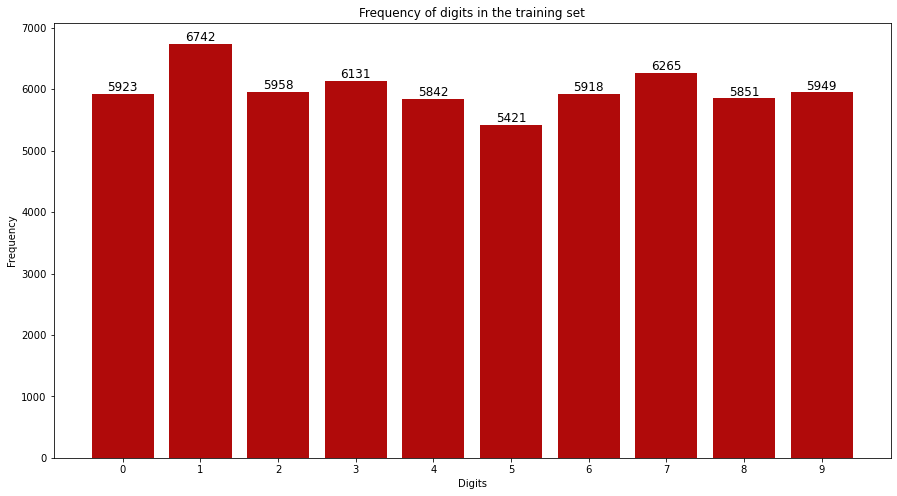

In [12]:
#Determining frequency of each digit within the training dataset
train_digits, train_counts = np.unique(train_labels, return_counts = True)
train_freq = dict(zip(train_digits,train_counts))
print("Training set digit frequency: \n" ,train_freq)

#plotting a bar chart for the frequency
plt.figure(figsize=(15,8))
plt.bar(*zip(*train_freq.items()), color = '#B00A0A')
addlabels(list(train_freq.keys()),list(train_freq.values()))
plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.title("Frequency of digits in the training set")
plt.show()



Test set digit frequency: 
 {'0': 980, '1': 1135, '2': 1032, '3': 1010, '4': 982, '5': 892, '6': 958, '7': 1028, '8': 974, '9': 1009}


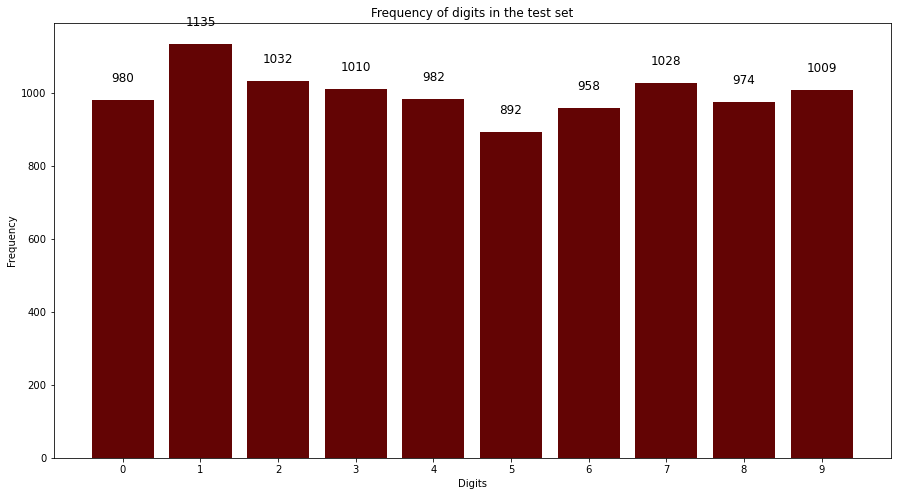

In [13]:
#Determining frequency of each digit within the test dataset
test_digits, test_counts = np.unique(test_labels, return_counts = True)
test_freq = dict(zip(test_digits, test_counts))
print("Test set digit frequency: \n", test_freq)

plt.figure(figsize=(15,8))
plt.bar(*zip(*test_freq.items()), color = '#630404')
addlabels(list(test_freq.keys()),list(test_freq.values()))
plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.title("Frequency of digits in the test set")
plt.show()


## 2. Visualizing an image

Remember that each image is stored as a 784 dimensional vector. To visualize an image, we need to first reshape it to a 28 by 28 image

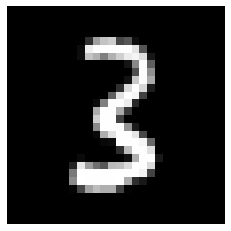

Label 3


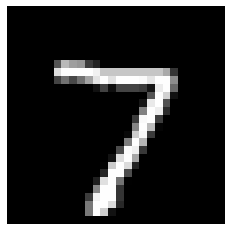

Label 7


In [67]:
## Define a function that displays a digit given its vector representation
def digit_visual(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap = plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def display(index, dataset = "train_set"):
    if dataset == "train_set":
        digit_visual(train_data[index])
        label = train_labels[index]
    else:
        digit_visual(test_data[index])
        label = test_labels[index]
    print("Label " + str(label))

## Lets view a random data point in the training set by giving its index
display(50000, "train_set")

## Now lets view a random data point in the test set by giving its index
display(0, "test_set")

## 3. Euclidean distance

Lets start off by reviewing what the euclidean distance is in two dimensions. if we have two points (x1,y1) and (x2,y2) the euclidean distance between these two points is simply the straight line connecting these two points. 

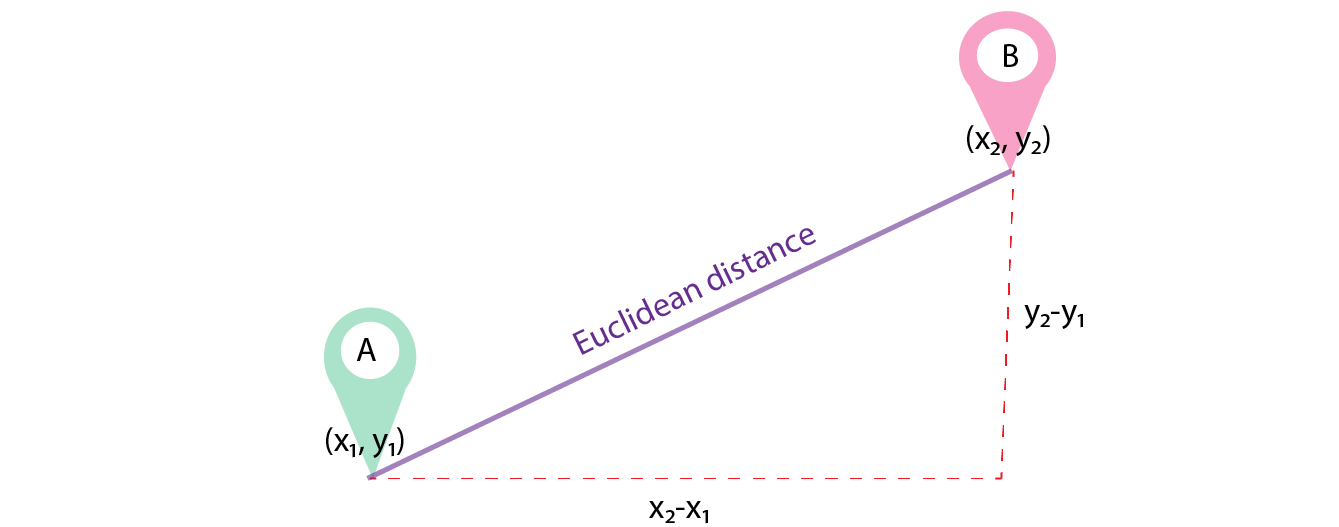

Notice that these points differ along the first coordinate by ($x_2 - x_1$) and along the second coordinate by ($y_2-y_1$) and therefore the length of the straight line connecting the two is the square root of $\sqrt (x_2-x_1)^2 + (y_2-y)^2\$

For any d dimensions the euclidean distance is defined as follows:
$$\|x - y\| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}.$$

Often we omit the square root, and simply compute _squared Euclidean distance_:
$$\|x - y\|^2 = \sum_{i=1}^d (x_i - y_i)^2.$$
For the purposes of nearest neighbor computations, the two are equivalent: for three vectors $x, y, z \in \mathbb{R}^d$, we have $\|x - y\| \leq \|x - z\|$ if and only if $\|x - y\|^2 \leq \|x - z\|^2$.

Since the squared euclidean distance is rquivalent to the general euclidean distance formula in our case, we will simply use the squared euclidean distance






In [ ]:
## calculates the squared euclidean distance between two vectors
def squared_euclidean(x,y):
    return np.sum(np.square(x-y))

## 4. Prototype

Before we compute the Nearest Neighbor with the euclidean method, there is one very important thing that we need to consider, performing the nearest neighbor requires a full pass through the training set, which means that each point in the training set is compared to each point in the rest of the training set. If there are $N$ training points in $R^d$ , this takes $O(N d)$ time

We therefore cannot use 60,000 * 784 points since that will take too long. One way to speed up this process is through carefully choosing a subset of the training set to use in the classifier. The selected points are thought of as prototypes. 

Now there are statistical ways to select these prototypes, however we will not go through them but feel free to look them up if you want. Instead, we will choose these prototypes at random from the training set and then run our nearest neighbor clasifier on them 

In [ ]:
"""
given a positive integer N, less than the length of the training set, 
returns a random subset of the training set of length N with the corresponding labels
"""
def rand_prototypes(N, dataset = 'train'):
    if dataset == 'train':
        indices = np.random.choice( len(train_labels) , N, replace=False)
        return train_data[indices,:], train_labels[indices]
    else:
        indices = np.random.choice( len(test_labels) , N, replace=False)
        return test_data[indices,:], test_labels[indices]

Lets test the ran_prototype function, with N = 7500 and compare it to our original training set of 60,000 images

In [ ]:
prototype_train_data, prototype_train_labels = rand_prototypes(7500)
prototype_test_data, prototype_test_labels = rand_prototypes(1000,'test')

print("Shape of train_data:", train_data.shape)
print("Shape of array of prototypes of training data: ", prototype_train_data.shape)

print("Shape of test_data:", test_data.shape)
print("Shape of array of prototypes of test data: ", prototype_test_data.shape)

## 5. Nearest Neighbor classifier computation

Now that we have defined our distance function and gotten our prototypes for both the train and the test data, we can turn to nearest neighbor classification

In [ ]:
## Takes a vector x and returns the index of its nearest neighbor in train_data
def NearestN(x):
    # Compute distances from x to every row in train_data
    distances = [squared_euclidean(x,prototype_train_data[i,]) for i in range(len(prototype_train_labels))]
    # Get the index of the smallest distance
    return np.argmin(distances)

## Takes a vector x and returns the class of its nearest neighbor in train_data
def NearestN_classifier(x):
    # Get the index of the the nearest neighbor
    index = NearestN(x)
    # Return its class
    return prototype_train_labels[index]

## 6. Applying the nearest neighbor classifier to the subset of the training data (prototype)

In [238]:
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = [NearestN_classifier(prototype_test_data[i,]) for i in range(len(prototype_test_labels))]
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, prototype_test_labels)
error = float(np.sum(err_positions))/len(prototype_test_labels)

print("Error of nearest neighbor classifier: ", error*100, "%")
print("Classification time (seconds): ", t_after - t_before)

Error of nearest neighbor classifier:  5.5 &
Classification time (seconds):  60.96961998939514


## 8. Pause and Reflect
We have so far seen how to implement the nearest neighbor classifier from scratch. We now have a thorough grounding of the basics behind NN and therefore we can now move on to applying the Nearest neighbor classifier on the whole training set. Before doing that, notice that we get an error rate of just 5.5 %. With such a simple classifier we have gotten a very small error rate. It makes sense that if we train the classifier on the whole training set we will get a better result. And this is something we will see now

## 7. Faster nearest neighbor methods

There are faster methods to perform nearest neighbor using `scikit-learn` implementations of two useful nearest neighbor data structures: the _ball tree_ and the _k-d tree_. 

In [63]:
from sklearn.neighbors import BallTree

## Build nearest neighbor structure on training data
t_before = time.time()
ball_tree = BallTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))
ball_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same

Time to build data structure (seconds):  45.316919803619385
Time to classify test set (seconds):  669.4102132320404


In [64]:
ball_tree_err_positions = np.not_equal(ball_tree_predictions, test_labels)
ball_tree_error = float(np.sum(ball_tree_err_positions))/len(test_labels)

print("Error of nearest neighbor classifier: ", ball_tree_error*100, "%")

Error of nearest neighbor classifier:  3.09 %


In [65]:
from sklearn.neighbors import KDTree

## Build nearest neighbor structure on training data
t_before = time.time()
kd_tree = KDTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(kd_tree.query(test_data, k=1, return_distance=False))
kd_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same

Time to build data structure (seconds):  32.6708710193634
Time to classify test set (seconds):  795.0816683769226


In [66]:
kd_tree_err_positions = np.not_equal(kd_tree_predictions, test_labels)
kd_tree_error = float(np.sum(kd_tree_err_positions))/len(test_labels)

print("Error of nearest neighbor classifier: ", kd_tree_error*100 , "%")

Error of nearest neighbor classifier:  3.09 %


## 9. Accuracy of nearest neighbor on MNIST

As we have seen using the nearest neighbor classfiier gives us an accuracy of 96.91 % with an error rate of 3.09 %. To put this in perspective consider a random classifier, one that picks a label 0 to 9 at random. This means that the classifier does not look at the data but guesses a number from 0 to 9 at random. The accuracy for such a classifier would be just 10 % since it will be right 1 out of 10 times. The error rate would therefore be 90 %. Nearest Neighbor does a great job considering how simple it is. 

However, we can still further improve on the accuracy of the classifier by tweaking our classifier a bit. We will look at two more ways to make the nearest neighbor classifier even more powerful.



## 10. K Nearest Neighbors

When doing nearest neighbors, instead of simply looking for the one closest point in the test set, find the closest say three points, or the closest five points. They each will have a label, return the majority label, or the most common label. Lets implement K nearest enighbors for a random value of k = 3. 

We will use scikit learns implementation of K nearest neighboirs intead of doing it from scratch. However, the idea will remain the same, we will still be using the euclidean distance to measure didstance between two vectors in $R^d$ space

In [29]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier(weights='distance', n_neighbors=3)
#Train the classifier
kNN.fit(train_data, train_labels)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [30]:
#predict on the test set
kNN_prediction = kNN.predict(test_data)

In [31]:
from sklearn.metrics import accuracy_score
#Compute the accuracy of the classifier
accuracy_score(test_labels, kNN_prediction)

0.9717

In [32]:
kNN_error = round((1 - accuracy_score(test_labels, kNN_prediction))*100,2)
print("KNearest Neighbors error rate: ",kNN_error, "%")

KNearest Neighbors error rate:  2.83 %


As you can see, we drastically improved our model from an error rate of 3.09 % to an error rate of 2.83 % by considering 3 nearest neighbors instead of just one. However, the question that arises here is what value of k or how many nearest neighbors should be look at. To find the optimum value of k we will have to check for each value of k with k being a positive integer greater than 0, which one yields the lowest error rate. 

Now one important thing to consider is that for testing different values of k we can not use the test set again and again since our classifier has already seen the test set when we tested it the first time. We therefore need to think of a way to test different values of k on the training set and then using that value of k that yields the least error to evaluate the test set. 

Solution: Gridsearch with Cross-validation

## 11. GridSearchCV

### Cross-validation:

Idea behind cross-validation: Suppose we want to evaluate a particular choice of k, e.g 3 nearest neighbor, k = 3. We want to estimate the error rate of k nearest neighbor but by only using the training set. We do this, by running a N-fold Cross validation. E.g a 10 fold cross validation would work as follows: 

-  Divide the training set into 10 equal pieces:
    -  In the case of MNIST data we divide the 60,000 points into 10 equal pieces of 6000 points each. Call the pieces $S_1,....,S_10$
    
    
-  Now for each piece, $S_i$:
    
    -  We will take just that chunk, the $S_i$, and we will think of it as the test set and we will think of the remaining nine chunks as the training set. 
    -  For each of the 6000 points in $S_i$ , we will classify it using the remaining 54,000 points. This will give us an error for each $S_i$ which we will call $epsilon_i$
    -  Once we do this for each piece, we will have 10 error rates, $epsilon_1$ to $epsilon_10$ for each $S_i$. We then average them to get an estimated error. We therefore need to pick that value of k that has the lowest estimated error
    
Now we can not manually go through this process for each value of k again and again. Fortunately, we have GridSearchCV for this very purpose which allows us to test different values of k by running them through the cross-validation. Lets see how this will work



In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights':["distance"], 'n_neighbors' : [3,4,5]}]

kNN_classifier = KNeighborsClassifier()
grid_search = GridSearchCV(kNN_classifier, param_grid, cv = 5, verbose = 3)
grid_search.fit(train_data,train_labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=15.0min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.0min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=14.2min
[CV] n_neighbors=3, weights=distance .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 29.2min remaining:    0.0s


[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=15.2min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=14.7min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.971, total=15.2min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.973, total=15.5min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.972, total=15.6min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.970, total=15.5min
[CV] n_neighbors=4, weights=distance .................................
[CV] ..... n_neighbors=4, weights=distance, score=0.971, total=15.8min
[CV] n_neighbors=4, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 233.1min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5], 'weights': ['distance']}],
             verbose=3)

In [24]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [25]:
grid_search.best_score_

0.9716166666666666

In [28]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(test_data)
accuracy_score(test_labels, y_pred)

0.9714

## 12. Image Augmentation

Lastly we will use a technique called data augmentation or training set expansion to increase our training set by shifting each image to the left, to the right, up and down by a certain number of pixels and then train the best model that we got from our GridSearchCV on this expanded training set 

In [33]:
from scipy.ndimage.interpolation import shift


In [34]:
#returns an image shifted by the specified number of pixels
def shift_image(image, x, y):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [y, x], cval=0, mode="constant")
    return shifted_image.reshape([-1])

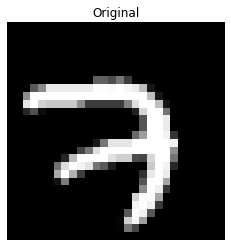

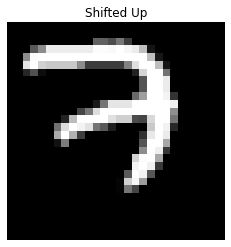

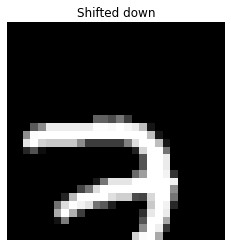

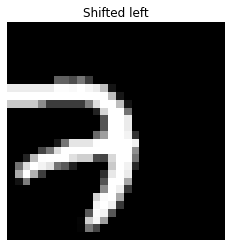

In [35]:
#Test image to see the output of out shift_image function
image = train_data[5000]
shifted_image_up = shift_image(image, 0, -5)
shifted_image_down = shift_image(image, 0, 5)
shifted_image_right = shift_image(image, 5, 0)
shifted_image_left = shift_image(image, -5, 0)

plt.title("Original")
digit_visual(image)

plt.title("Shifted Up")
digit_visual(shifted_image_up)

plt.title("Shifted down")
digit_visual(shifted_image_down)

plt.title("Shifted left")
digit_visual(shifted_image_left)

In [42]:
train_data_expanded = [image for image in train_data]
train_labels_expanded = [label for label in train_labels]

for x, y in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(train_data, train_labels):
        train_data_expanded.append(shift_image(image, x, y))
        train_labels_expanded.append(label)

train_data_expanded = np.array(train_data_expanded)
train_labels_expanded = np.array(train_labels_expanded)

In [43]:
shuffle_index = np.random.permutation(len(train_data_expanded))
train_data_expanded = train_data_expanded[shuffle_index]
train_labels_expanded = train_labels_expanded[shuffle_index]

In [44]:
#Lets check the shapoe of our expanded test set
print("Original Test dataset: ", train_data.shape)
print("Expanded Test dataset: ", train_data_expanded.shape)

print("Original Labels: ", len(train_labels))
print("Expanded Labels: ", len(train_labels_expanded))

Original Test dataset:  (60000, 784)
Expanded Test dataset:  (300000, 784)
Original Labels:  60000
Expanded Labels:  300000


In [45]:
kNN_classifier_expanded = KNeighborsClassifier(**grid_search.best_params_)

In [49]:
kNN_classifier_expanded.fit(train_data_expanded, train_labels_expanded)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [50]:
kNN_expanded_prediction = kNN_classifier_expanded.predict(test_data)
accuracy_score(test_labels, kNN_expanded_prediction)

0.9763

In [52]:
accuracy = accuracy_score(test_labels, kNN_expanded_prediction)

In [55]:
error = round(((1 - accuracy)*100),2)
print(error,"%")

2.37 %


## 13. Conclusion

So we managed to build a pretty good classifier considering that the algorithm used was pretty simple. We started off by looking at the nearest neighbor with k = 1 and then we tweaked the model to look at multiple nearest neighbors instead of one. We also looked at a technique called data expansion where we expanded our dataset so that our clasiifier had more data points to learn from which lead to a even better predictions. In the end we acchieved an accuracy score of 0.9763. 